In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product j.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_j= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_j.shape

(60, 1)

In [5]:
sales_j.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_j['Sales'].sum()

4532957

Text(0.5, 1.0, 'Product J')

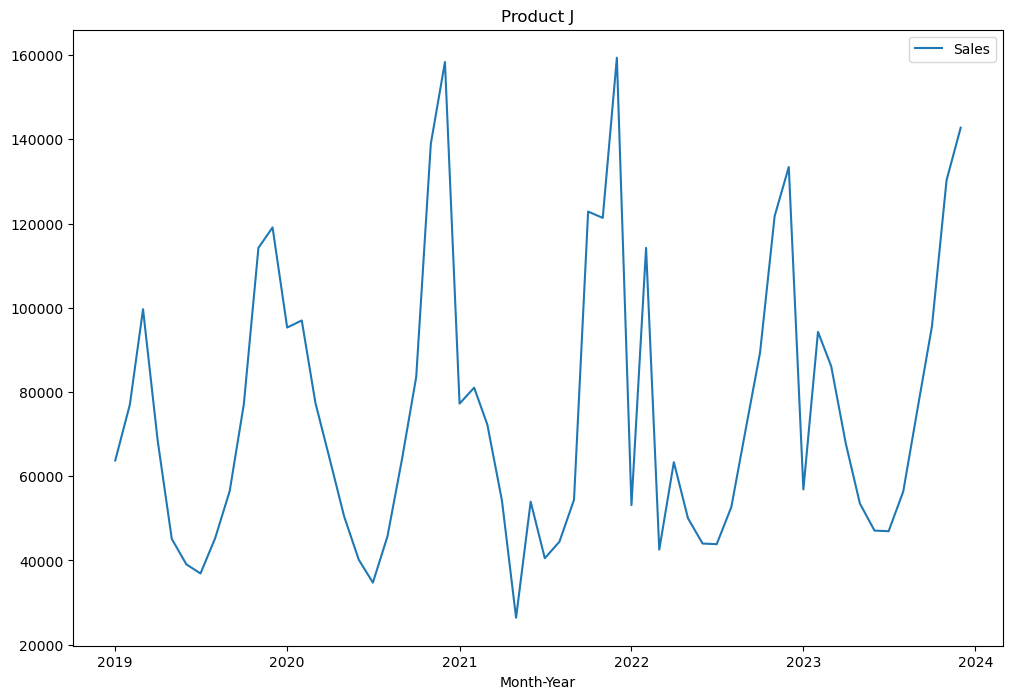

In [7]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_j)
plt.title('Product J')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_j)

ADF Statistics: -2.3759301997991913
p- value: 0.14864548261740318
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_j_diff= sales_j.diff().dropna()

Text(0.5, 1.0, 'Product J- First Difference')

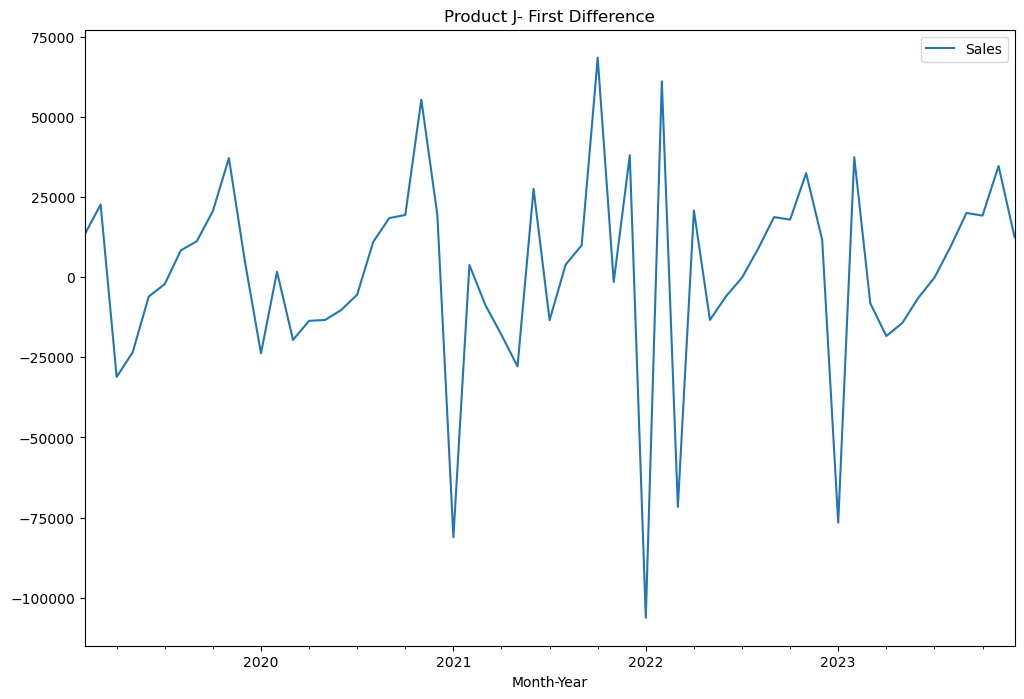

In [11]:
sales_j_diff.plot(figsize=(12,8))
plt.title('Product J- First Difference')

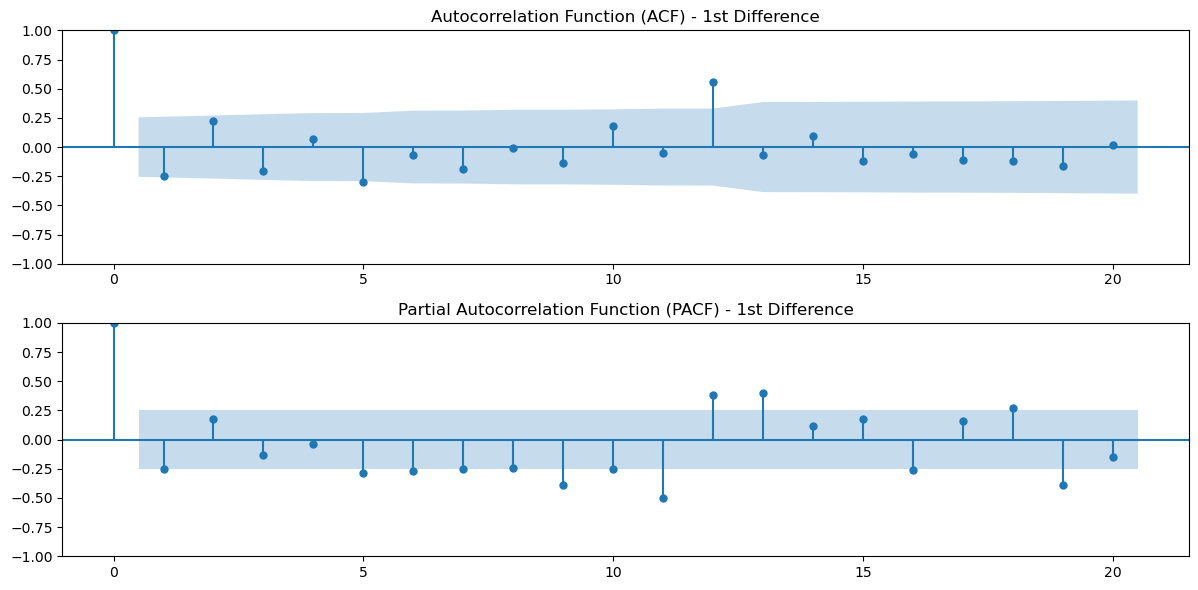

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_j_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_j_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_j_diff)

ADF Statistics: -6.410493361286657
p- value: 1.896152982571653e-08
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_j[:48]
test=sales_j[48:]

In [15]:
len(train)

48

In [16]:
#the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2,3) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(0,1,1),(0,1,2),(0,1,3),(1,1,0),(1,1,1),(1,1,2),(1,1,3),(2,1,0), (2,1,1), (2, 1, 2),(2,1,3),(3,1,0),(3,1,1),(3,1,2),(3,1,3),(4,1,0),(4,1,1),(4,1,2),(4,1,3),(5,1,0),(5,1,1),(5,1,2),(5,1,3)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_i, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_j)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
11  3  2  1099.719239  1110.820124  16753.111205  5.130585e+08  22650.795366
17  5  2  1101.253523  1116.054704  16569.630218  4.868840e+08  22065.447266
10  3  1  1101.940575  1111.191313  23013.165115  9.750381e+08  31225.599811
16  5  1  1102.726600  1115.677633  18469.668343  6.869126e+08  26209.018121
13  4  1  1103.715029  1114.815915  21694.471594  8.877691e+08  29795.454371
14  4  2  1104.992891  1117.943924  22960.457816  9.775061e+08  31265.093193
4   1  1  1107.591603  1113.142046  55382.254296  3.818949e+09  61797.648297
6   2  0  1108.241684  1113.792127  63833.975834  4.988768e+09  70631.210916
9   3  0  1108.288114  1115.688705  52963.401174  3.506572e+09  59216.317632
15  5  0  1108.580118  1119.681004  39414.590302  1.838039e+09  42872.355912
7   2  1  1108.867756  1116.268347  59364.380704  4.357226e+09  66009.288206
5   1  2  1109.322402  1116.722992  58630.654087  4.256076e+09  65238.605398

In [20]:
m_arima= ARIMA (train, order=(3,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -543.860
Date:                Thu, 09 May 2024   AIC                           1099.719
Time:                        18:53:37   BIC                           1110.820
Sample:                    01-01-2019   HQIC                          1103.897
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1475      0.241      4.752      0.000       0.674       1.621
ar.L2         -0.0984      0.332     -0.296      0.767      -0.750       0.553
ar.L3         -0.4435      0.209     -2.123      0.0

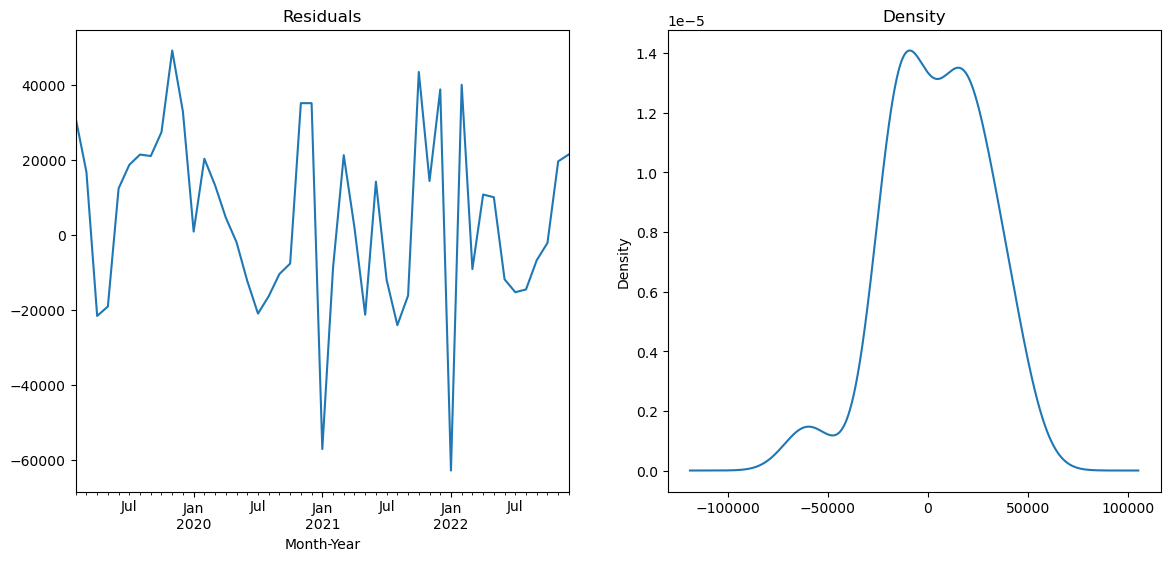

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

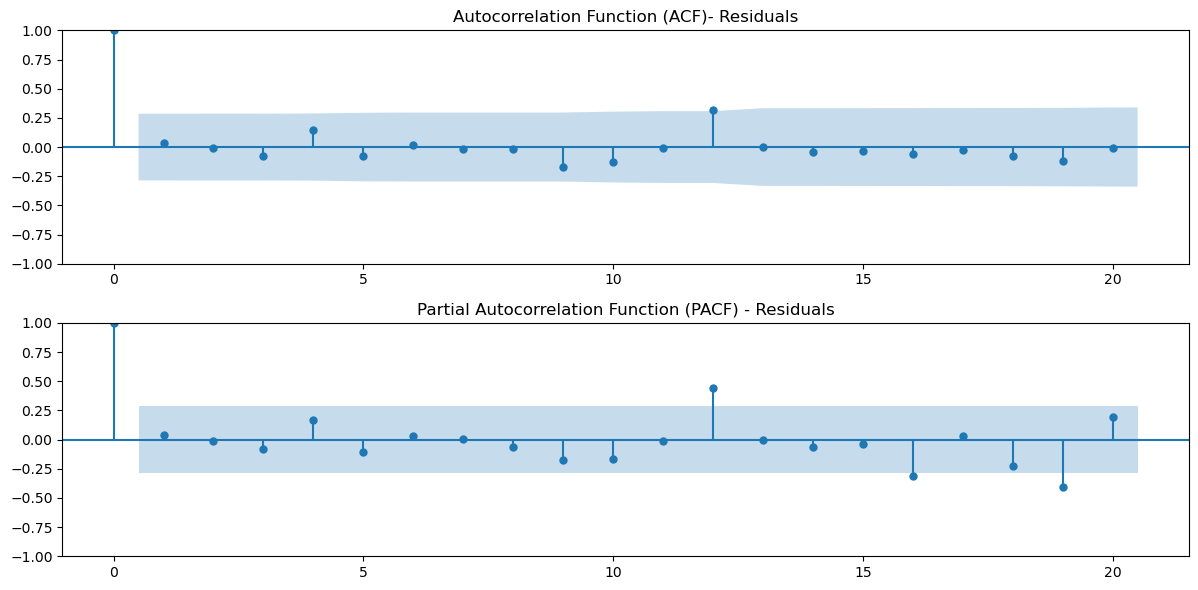

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

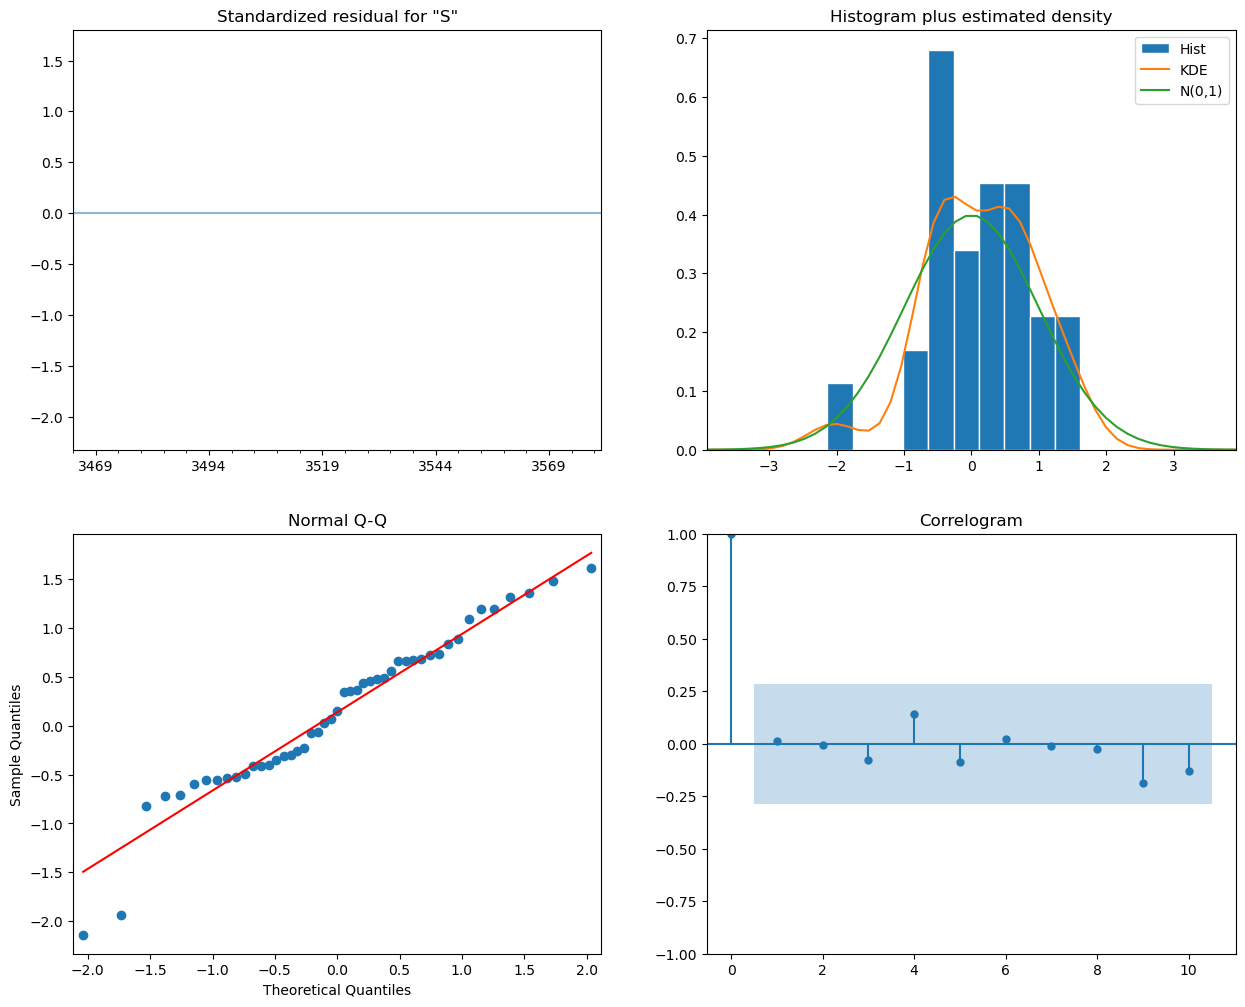

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_j['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_j.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_j)-1), dynamic = True)
sales_j['Forecast_ARIMA']=[None]*len(train) + list(pred)

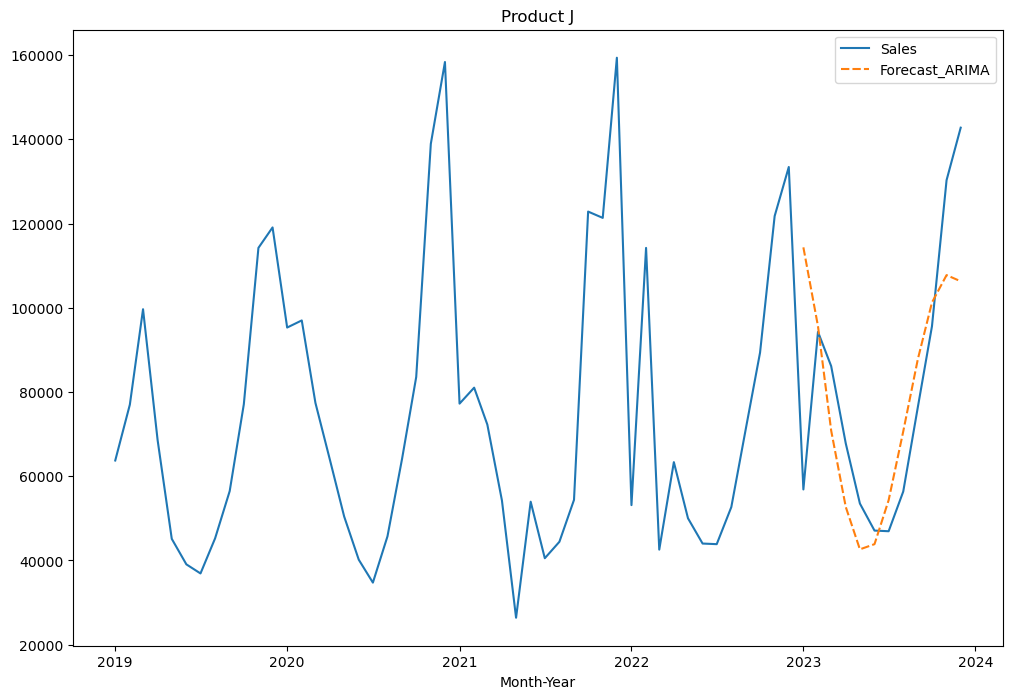

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j)
plt.title('Product J')
plt.show()

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 16753.111205159094
MAPE - ARIMA: 0.22875203246575268
MSE - ARIMA: 513058530.71796316
RMSE - ARIMA: 22650.795366122646


# SARIMA

In [33]:
import statsmodels.api as sm

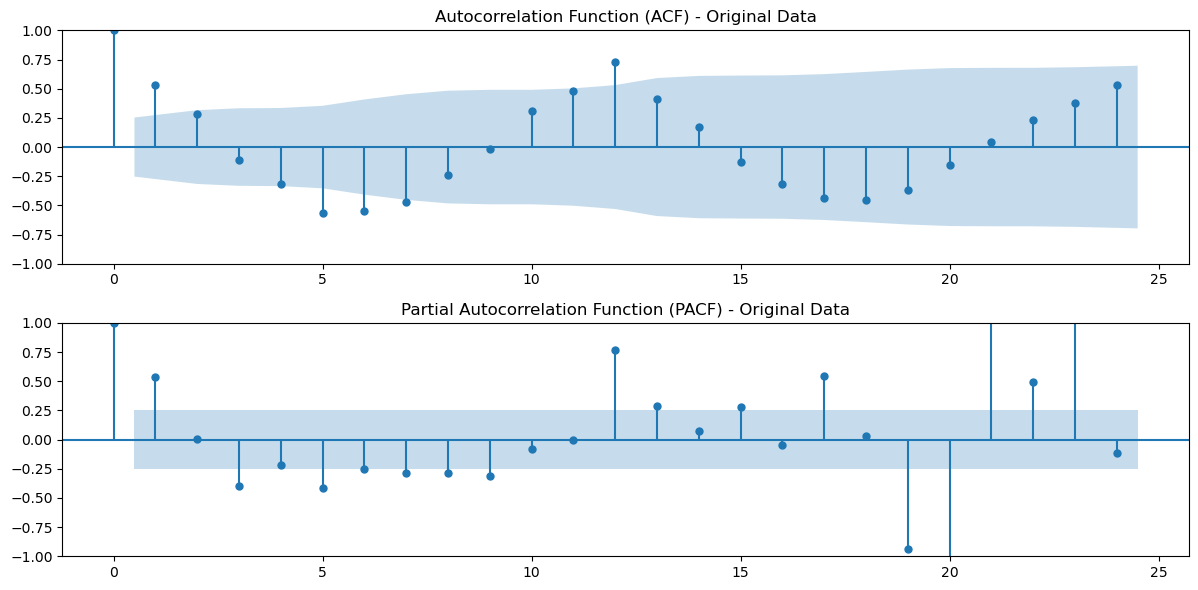

In [28]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_j['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_j['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

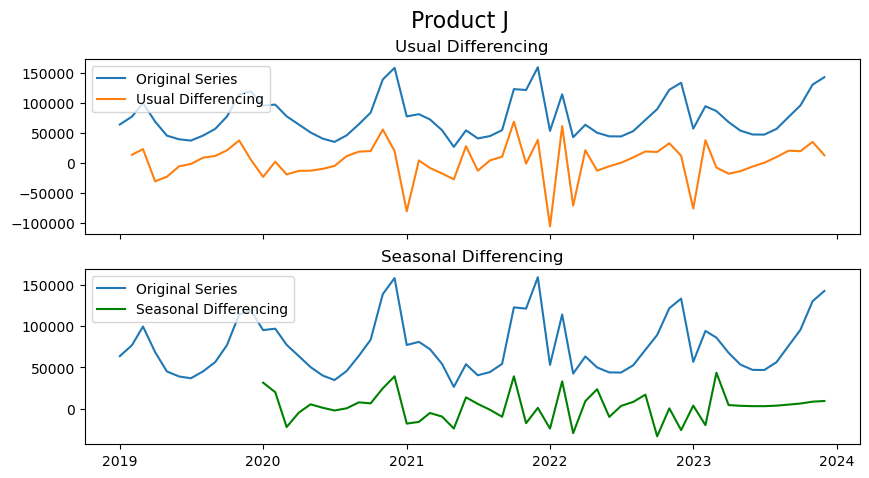

In [29]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_j['Sales'], label='Original Series')
axes[0].plot(sales_j['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_j['Sales'], label='Original Series')
axes[1].plot(sales_j['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product J', fontsize=16)
plt.show()

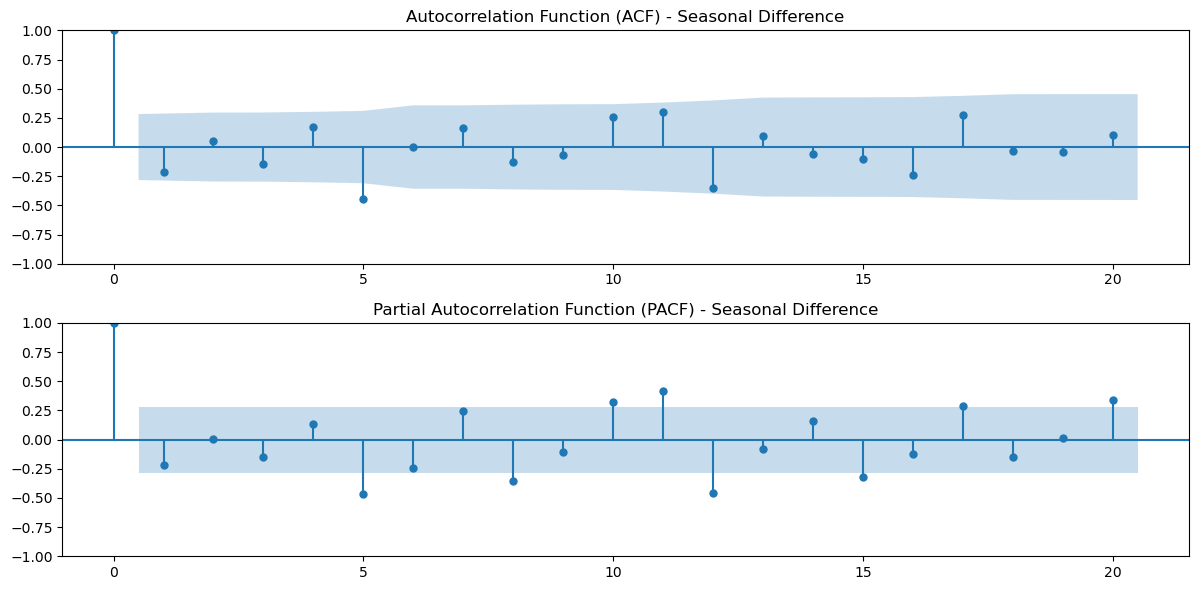

In [30]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_j['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_j['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

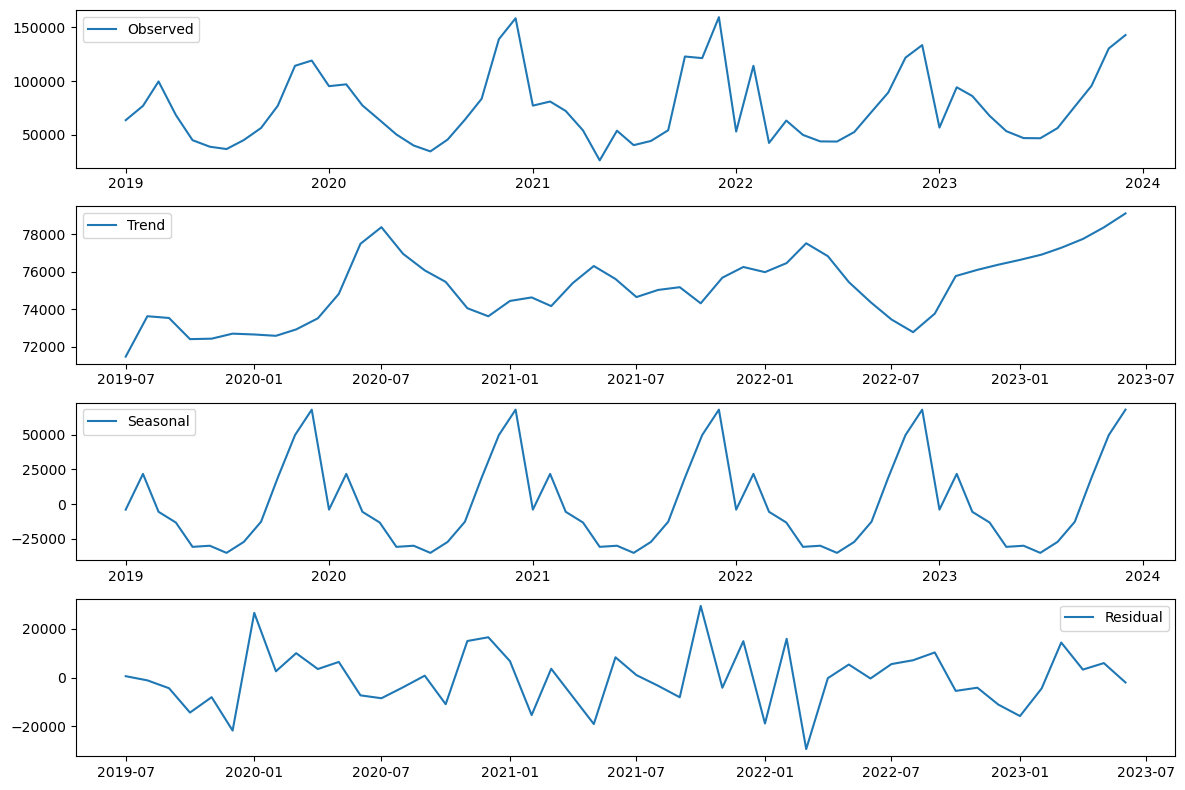

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_j['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [34]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(2):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(3, 1, 2), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=48, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [35]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q         aic         bic           mae           mse
0   0  0  812.883532  822.215621  30307.485119  1.034706e+09
1   0  1  814.858051  825.745487  29341.486157  9.674865e+08
2   1  0  814.882210  825.769646  29621.337109  9.857377e+08
3   1  1  815.841619  828.284404  19265.131341  4.726200e+08
6   3  0  816.086139  830.084272  19755.560137  4.826664e+08
4   2  0  816.722429  829.165213  27415.583945  8.637898e+08
5   2  1  817.551000  831.549132  14320.259006  2.952019e+08
8   4  0  817.920811  833.474292  23886.373929  6.674196e+08
7   3  1  817.933053  833.486533  22934.622147  6.164765e+08
10  5  0  819.916532  837.025361  24006.311738  6.735468e+08
9   4  1  819.916993  837.025822  23814.712791  6.642256e+08
11  5  1  821.915801  840.579978  23725.187602  6.598145e+08


In [36]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(3, 1, 2),seasonal_order=(0,1,0,12))
sarima_model=sarima.fit()

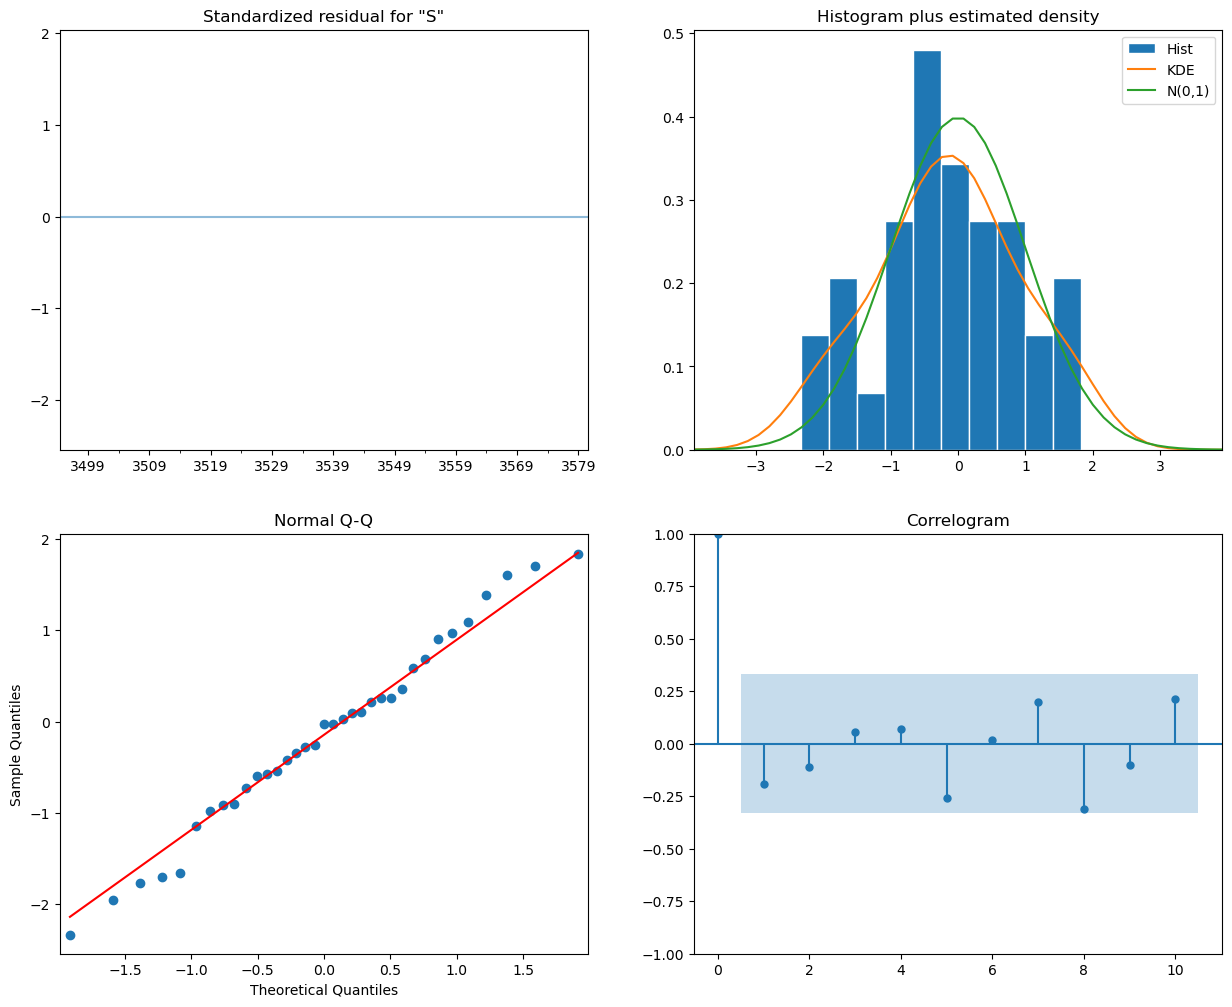

In [37]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [38]:
forecast_test_sarima=sarima_model.predict(start=48,end=59,dynamic=True)

In [39]:
sales_j['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product J')

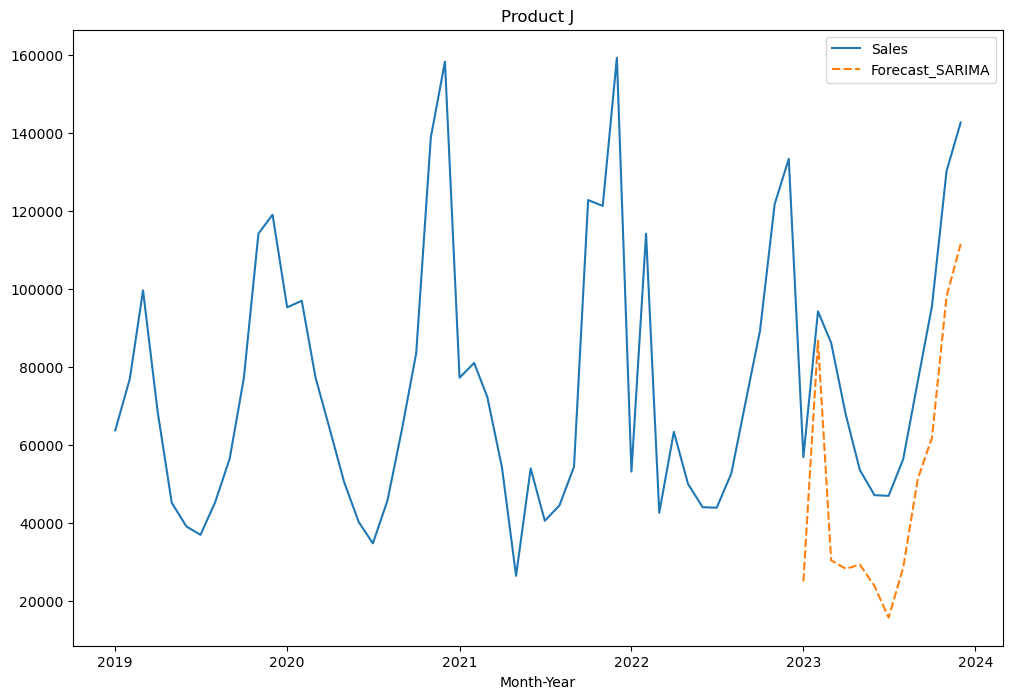

In [40]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j[['Sales','Forecast_SARIMA']])
plt.title('Product J')

In [41]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 30307.485
MAPE - SARIMA: 0.427
MSE - SARIMA: 1034705690.679
RMSE - SARIMA: 32166.841


# AUTO-ARIMA

In [42]:
import pmdarima as pm

In [43]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=6 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=822.366, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=822.181, Time=0.08 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=824.201, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=822.151, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=823.904, Time=0.25 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=825.599, Time=0.17 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=825.010, Time=1.06 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=826.914, Time=1.84 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=828.841, Time=3.77 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=827.010, Time=1.46 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=828.914, Time=1.66 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=829.010, Time=3.15 sec
 ARIMA(0,1,1)(0,1,0)[1

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [43]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -404.761
Date:                            Mon, 29 Apr 2024   AIC                            813.521
Time:                                    20:35:31   BIC                            816.632
Sample:                                01-01-2019   HQIC                           814.595
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4391      0.097     -4.508      0.000      -0.630      -0.248
sigma2      5.709e+08   4.78e-12   1.19e+20      0.000    5.71e+08    5.71e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.28   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.26   Prob(JB):                         0.77
Heteroskedasticity (H):               0.98   Skew:                            -0.20
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.48e+37. Standard errors may be unstable.
"""

In [ ]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [44]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_j['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_j.plot()

Text(0.5, 1.0, 'Product J')

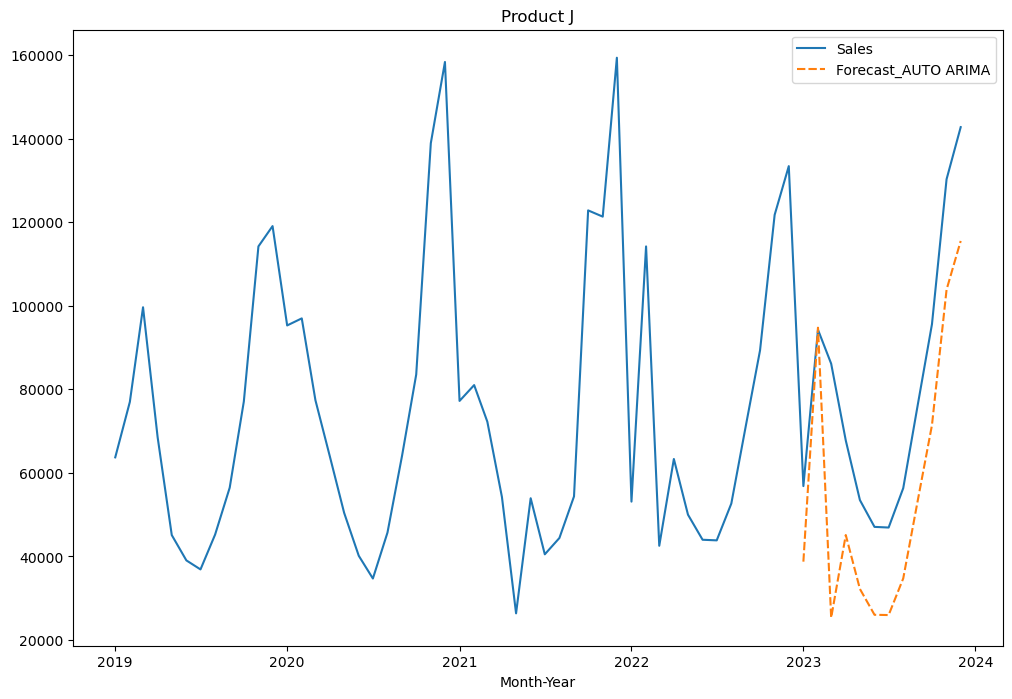

In [45]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product J')

In [46]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 23964.858086872206
MAPE - AUTO ARIMA: 0.33194854711394367
MSE - AUTO ARIMA: 740366670.3103
RMSE - AUTO ARIMA: 27209.679717157644


In [47]:
sales_j.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,56843,114335.580383,24926.768321,38758.168644
2023-02-01,94268,95602.174553,86766.857512,94754.648601
2023-03-01,86135,70818.189124,30345.222924,25338.593314
2023-04-01,67767,52684.472912,28183.856893,45131.661752
2023-05-01,53500,42623.193672,29256.007529,32229.391628
2023-06-01,47080,43853.919517,23759.189458,26040.256898
2023-07-01,46924,54298.513401,15623.267460,25977.306503
2023-08-01,56348,70624.696598,28552.411567,34748.839182
2023-09-01,76393,87785.350267,51265.601352,53498.852088


In [48]:
sales_j.mean()

Sales                  75549.283333
Forecast_ARIMA         78990.933816
Forecast_SARIMA        49184.598215
Forecast_AUTO ARIMA    55608.333347
dtype: float64

In [49]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,16753.111205,0.228752,5.130585e+08,22650.795366
AUTO ARIMA,23964.858087,0.331949,7.403667e+08,27209.679717
SEASONAL ARIMA,30307.485119,0.427424,1.034706e+09,32166.841478


# TESTING

In [18]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=815.760, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=816.527, Time=0.09 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=817.970, Time=0.29 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=816.700, Time=0.09 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=818.294, Time=0.29 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=817.701, Time=0.26 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=820.025, Time=1.14 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=817.889, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=818.390, Time=0.17 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=819.907, Time=0.37 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=818.578, Time=0.09 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=820.194, Time=0.43 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,0,1)(2,1,0)[1

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [19]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -405.880
Date:                  Wed, 08 May 2024   AIC                            815.760
Time:                          20:15:33   BIC                            818.927
Sample:                      01-01-2019   HQIC                           816.865
                           - 12-01-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1045.7500   3236.297      0.323      0.747   -5297.276    7388.776
sigma2      3.634e+08   1.05e+08      3.464      0.001    1.58e+08    5.69e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.22   Prob(JB):                         0.65
Heteroskedasticity (H):               1.39   Skew:                             0.22
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_j['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product J')

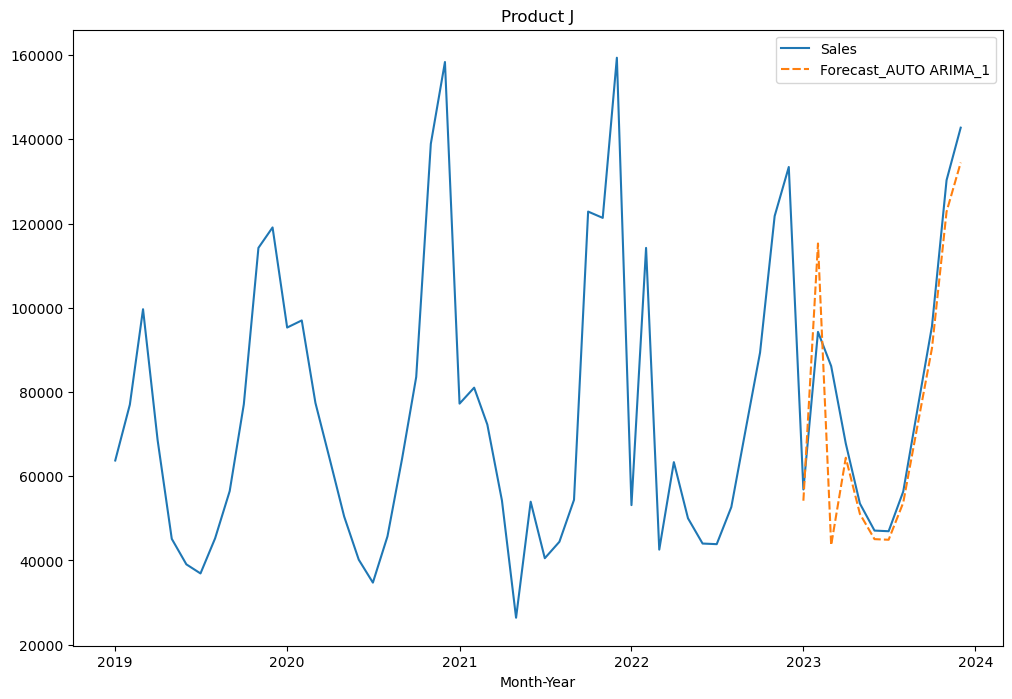

In [21]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product J')

In [22]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 8638.458333333334
MAPE - AUTO ARIMA: 0.10118087776206881
MSE - AUTO ARIMA: 204713259.85416666
RMSE - AUTO ARIMA: 14307.804159065312
